In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Hyperparameter Selection Comparison

In [2]:
# List all available dataset_model combinations
proj_type = "sjlt"
hyperparam_results_dir = "./results/hyperparam_selection"

# Find all available result files
import glob
result_files = glob.glob(f"{hyperparam_results_dir}/*_{proj_type}.pt")
print(f"Found {len(result_files)} result files:")
for f in result_files:
    print(f"  - {os.path.basename(f)}")

# Load all results
all_results = {}
for result_file in result_files:
    basename = os.path.basename(result_file).replace(f"_{proj_type}.pt", "")
    results = torch.load(result_file, map_location="cpu", weights_only=False)
    all_results[basename] = results
    print(f"\nLoaded {basename}: dataset={results.get('dataset', '?')}, model={results.get('model', '?')}")

Found 3 result files:
  - cifar2_resnet9_sjlt.pt
  - mnist_lr_sjlt.pt
  - mnist_mlp_sjlt.pt

Loaded cifar2_resnet9: dataset=cifar2, model=resnet9

Loaded mnist_lr: dataset=mnist, model=lr

Loaded mnist_mlp: dataset=mnist, model=mlp


Hyperparameter Selection

Step 1: Lambda sweep (fixed large m)

mnist_lr:
  Number of trials: 5
  Best λ*: 5.4e-02
  Confidence Intervals (95%, n=5):
    λ=1.0e-08: LDS=0.0763 ± 0.0244 [0.0519, 0.1007] (std=0.0196)
    λ=1.6e-08: LDS=0.0813 ± 0.0244 [0.0569, 0.1057] (std=0.0197)
    λ=2.6e-08: LDS=0.0862 ± 0.0237 [0.0625, 0.1099] (std=0.0190)
    λ=4.1e-08: LDS=0.0920 ± 0.0228 [0.0691, 0.1148] (std=0.0184)
    λ=6.6e-08: LDS=0.0982 ± 0.0213 [0.0769, 0.1196] (std=0.0172)
    λ=1.0e-07: LDS=0.1047 ± 0.0187 [0.0860, 0.1235] (std=0.0151)
    λ=1.7e-07: LDS=0.1107 ± 0.0177 [0.0930, 0.1284] (std=0.0143)
    λ=2.7e-07: LDS=0.1166 ± 0.0172 [0.0994, 0.1338] (std=0.0138)
    λ=4.3e-07: LDS=0.1234 ± 0.0165 [0.1069, 0.1399] (std=0.0133)
    λ=6.9e-07: LDS=0.1312 ± 0.0152 [0.1160, 0.1465] (std=0.0122)
    λ=1.1e-06: LDS=0.1391 ± 0.0163 [0.1228, 0.1555] (std=0.0131)
    λ=1.8e-06: LDS=0.1479 ± 0.0163 [0.1316, 0.1642] (std=0.0131)
    λ=2.8e-06: LDS=0.1574 ± 0.0141 [0.1433, 0.1715] (std=0.0113)
    λ

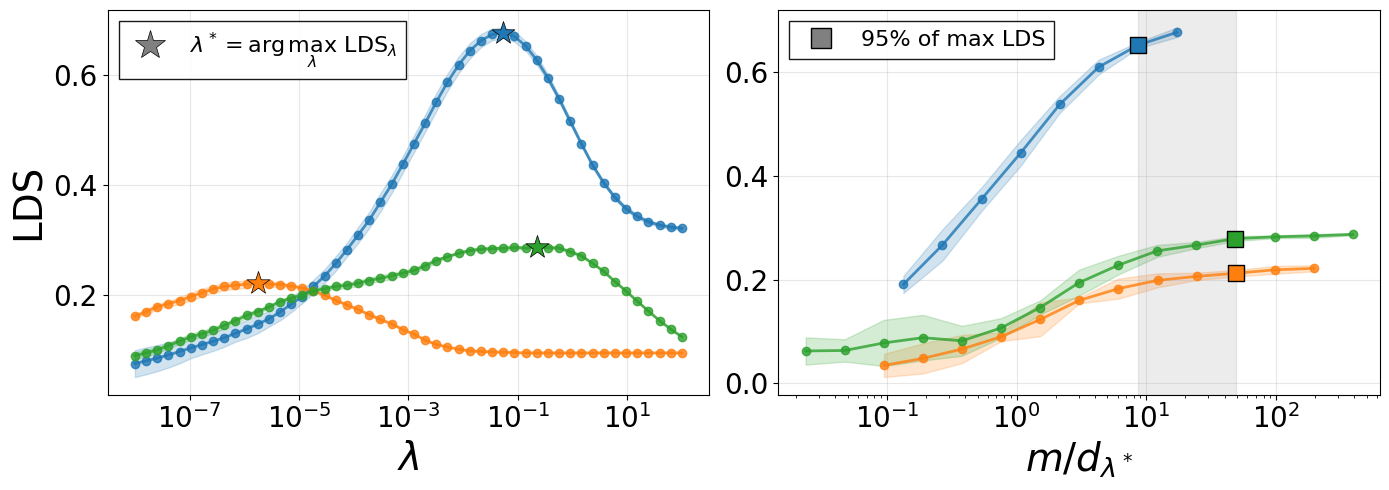



Unified legend:
Saved legend to ./figures/hyperparameter_selection/legend.pdf


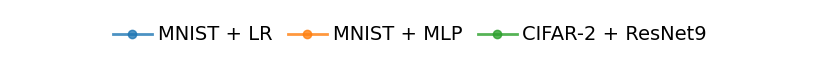


Summary of c_95% values:
  mnist_lr: c_95% = 8.59
  mnist_mlp: c_95% = 48.79
  cifar2_resnet9: c_95% = 48.55


In [7]:
def plot_hyperparam_selection(all_results: dict, save_path=None, figsize=(14, 5), ci_alpha=0.2):
    """
    Plot hyperparameter selection: Lambda sweep (left) and m sweep (right).

    Shows averaged curves across trials. Confidence intervals are automatically shown
    when multiple trials are available.

    Style matched to spectrum_bounds.ipynb bilinear error plots.
    """
    from matplotlib.lines import Line2D

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Color scheme for different dataset-model combos
    colors = {
        'mnist_lr': '#1f77b4',      # blue
        'mnist_mlp': '#ff7f0e',     # orange
        'cifar2_resnet9': '#2ca02c' # green
    }

    # Fixed order for plotting
    plot_order = ['mnist_lr', 'mnist_mlp', 'cifar2_resnet9']

    # =============================================================================
    # LEFT PLOT: Lambda sweep
    # =============================================================================
    print("\nStep 1: Lambda sweep (fixed large m)")
    print("=" * 50)

    for name in plot_order:
        if name not in all_results:
            continue
        results = all_results[name]
        color = colors.get(name, 'gray')

        lambda_vals = results["lambda_sweep"]["lambda_values"]
        val_lds = results["lambda_sweep"]["val_lds"]
        best_lambda = results["lambda_sweep"]["best_lambda"]
        num_trials = results["lambda_sweep"].get("num_trials", 1)

        print(f"\n{name}:")
        print(f"  Number of trials: {num_trials}")
        print(f"  Best λ*: {best_lambda:.1e}")

        # Plot the curve
        ax1.semilogx(lambda_vals, val_lds, 'o-', color=color,
                     markersize=6, linewidth=2, alpha=0.8)

        # Always show CI when multiple trials available
        if num_trials > 1 and "per_trial_results" in results["lambda_sweep"]:
            per_trial = results["lambda_sweep"]["per_trial_results"]
            # Compute std across trials for each lambda
            val_lds_std = []
            for i, lamb in enumerate(lambda_vals):
                trial_values = [trial["val_lds"][i] for trial in per_trial]
                std = np.std(trial_values, ddof=1) if len(trial_values) > 1 else 0.0
                val_lds_std.append(std)

            # Compute confidence interval (95%)
            t_value = 1.96 if num_trials > 30 else {2: 12.71, 3: 4.30, 4: 3.18, 5: 2.78,
                                                      6: 2.57, 7: 2.45, 8: 2.36, 9: 2.31,
                                                      10: 2.26}.get(num_trials, 2.0)
            val_lds_se = np.array(val_lds_std) / np.sqrt(num_trials)
            val_lds_ci = t_value * val_lds_se
            val_lds_lower = np.array(val_lds) - val_lds_ci
            val_lds_upper = np.array(val_lds) + val_lds_ci

            ax1.fill_between(lambda_vals, val_lds_lower, val_lds_upper, color=color, alpha=ci_alpha)

            # Print detailed CI information
            print(f"  Confidence Intervals (95%, n={num_trials}):")
            for i, lamb in enumerate(lambda_vals):
                print(f"    λ={lamb:.1e}: LDS={val_lds[i]:.4f} ± {val_lds_ci[i]:.4f} "
                      f"[{val_lds_lower[i]:.4f}, {val_lds_upper[i]:.4f}] "
                      f"(std={val_lds_std[i]:.4f})")
        else:
            print(f"  Single trial - no confidence intervals")
            for i, lamb in enumerate(lambda_vals):
                print(f"    λ={lamb:.1e}: LDS={val_lds[i]:.4f}")

        # Mark the best lambda* with a star
        best_idx = lambda_vals.index(best_lambda) if best_lambda in lambda_vals else \
                   val_lds.index(max(val_lds))
        ax1.scatter([lambda_vals[best_idx]], [val_lds[best_idx]],
                    s=300, c=color, marker='*', zorder=100, edgecolors='black', linewidths=0.5)

    # Add legend for the star marker
    star_handle = Line2D([0], [0], marker='*', color='gray', linestyle='None',
                        markersize=22, markeredgecolor='black', markeredgewidth=0.5)
    ax1.legend([star_handle], ['$\\lambda^* = \\arg\\max_{\\lambda}\ \\text{LDS}_\\lambda$'],
               loc='upper left', fontsize=16, frameon=True,
               fancybox=False, edgecolor='black', framealpha=0.9)

    ax1.set_xlabel('$\\lambda$', fontsize=28)
    ax1.set_ylabel('LDS', fontsize=28)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.grid(True, alpha=0.3)

    # =============================================================================
    # RIGHT PLOT: m sweep
    # =============================================================================
    print("\n\nStep 2: m sweep (fixed lambda*)")
    print("=" * 50)

    # Store c_95% values for the band
    c_95_values = {}

    for name in plot_order:
        if name not in all_results:
            continue
        results = all_results[name]
        color = colors.get(name, 'gray')

        best_lambda = results["lambda_sweep"]["best_lambda"]
        d_lambda_star = results["d_lambda"].get(
            best_lambda,
            results["d_lambda"][min(results["d_lambda"].keys(), key=lambda x: abs(x - best_lambda))]
        )

        m_vals = results["m_sweep"]["m_values"]
        m_lds = results["m_sweep"]["val_lds"]
        num_trials = results["m_sweep"].get("num_trials", 1)

        print(f"\n{name}:")
        print(f"  Number of trials: {num_trials}")
        print(f"  Fixed λ*: {best_lambda:.1e}")
        print(f"  d_λ*: {d_lambda_star:.1f}")

        # Normalize x-axis: c = m / d_lambda*
        c_vals = [m / d_lambda_star for m in m_vals]

        # Plot the curve
        ax2.semilogx(c_vals, m_lds, 'o-', color=color, markersize=6, linewidth=2, alpha=0.8)

        # Always show CI when multiple trials available
        if num_trials > 1 and "val_lds_std" in results["m_sweep"]:
            m_lds_std = results["m_sweep"]["val_lds_std"]

            # Compute confidence interval (95%)
            t_value = 1.96 if num_trials > 30 else {2: 12.71, 3: 4.30, 4: 3.18, 5: 2.78,
                                                      6: 2.57, 7: 2.45, 8: 2.36, 9: 2.31,
                                                      10: 2.26}.get(num_trials, 2.0)
            m_lds_se = np.array(m_lds_std) / np.sqrt(num_trials)
            m_lds_ci = t_value * m_lds_se
            m_lds_lower = np.array(m_lds) - m_lds_ci
            m_lds_upper = np.array(m_lds) + m_lds_ci

            ax2.fill_between(c_vals, m_lds_lower, m_lds_upper, color=color, alpha=ci_alpha)

            # Print detailed CI information
            print(f"  Confidence Intervals (95%, n={num_trials}):")
            for i, (m, c) in enumerate(zip(m_vals, c_vals)):
                print(f"    m={m:6d} (c={c:.2f}): LDS={m_lds[i]:.4f} ± {m_lds_ci[i]:.4f} "
                      f"[{m_lds_lower[i]:.4f}, {m_lds_upper[i]:.4f}] "
                      f"(std={m_lds_std[i]:.4f})")
        else:
            print(f"  Single trial - no confidence intervals")
            for i, (m, c) in enumerate(zip(m_vals, c_vals)):
                print(f"    m={m:6d} (c={c:.2f}): LDS={m_lds[i]:.4f}")

        # Find c_95% and mark it
        max_lds = max(m_lds)
        threshold_95 = 0.95 * max_lds
        c_95 = None
        for i, (c, lds_val) in enumerate(zip(c_vals, m_lds)):
            if lds_val >= threshold_95:
                c_95 = c
                # Mark the 95% point with a square marker
                ax2.scatter([c], [lds_val], s=120, c=color,
                            marker='s', zorder=5, edgecolors='black', linewidths=1)
                print(f"  95% threshold: m={m_vals[i]}, c={c:.2f}, LDS={lds_val:.4f} (max={max_lds:.4f})")
                break

        if c_95 is not None:
            c_95_values[name] = c_95

    # Get y-axis limits for the band
    ax2.autoscale()
    ylim = ax2.get_ylim()

    # Draw the c_95% band showing the range across all models
    if c_95_values:
        c_min = min(c_95_values.values())
        c_max = max(c_95_values.values())

        # Shaded band for the range of c_95% values
        ax2.axvspan(c_min, c_max, alpha=0.15, color='gray')

    # Add legend for the square marker
    square_handle = Line2D([0], [0], marker='s', color='gray', linestyle='None',
                          markersize=14, markeredgecolor='black', markeredgewidth=1)
    ax2.legend([square_handle], ['95% of max LDS'],
               loc='upper left', fontsize=16, frameon=True,
               fancybox=False, edgecolor='black', framealpha=0.9)

    ax2.set_xlabel('$m / d_{\\lambda^*}$', fontsize=28)
    # No ylabel for right plot to save space
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(ylim)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"\nSaved figure to {save_path}")

    plt.show()

    return c_95_values


def create_hyperparam_legend(save_path=None, figsize=(8, 0.5), fontsize=14):
    """
    Create a unified horizontal legend for hyperparameter selection plots.

    Style matched to spectrum_bounds.ipynb unified legend.
    """
    from matplotlib.lines import Line2D

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')

    # Color scheme
    colors = {
        'mnist_lr': '#1f77b4',
        'mnist_mlp': '#ff7f0e',
        'cifar2_resnet9': '#2ca02c'
    }

    display_names = {
        'mnist_lr': 'MNIST + LR',
        'mnist_mlp': 'MNIST + MLP',
        'cifar2_resnet9': 'CIFAR-2 + ResNet9'
    }

    plot_order = ['mnist_lr', 'mnist_mlp', 'cifar2_resnet9']

    handles = []
    labels = []

    # Add dataset-model curves
    for name in plot_order:
        color = colors[name]
        h = Line2D([0], [0], color=color, marker='o', linestyle='-',
                   markersize=6, linewidth=2, alpha=0.8)
        handles.append(h)
        labels.append(display_names[name])

    # Create horizontal legend with minimal padding
    legend = ax.legend(handles, labels, loc='center', ncol=len(handles),
                       fontsize=fontsize, frameon=False,
                       handletextpad=0.3, columnspacing=0.8,
                       borderpad=0, borderaxespad=0)

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        print(f"Saved legend to {save_path}")

    plt.show()
    return fig


# =============================================================================
# Save all figures as PDF
# =============================================================================

figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(f"{figures_dir}/hyperparameter_selection", exist_ok=True)

# Plot combined hyperparameter selection figure
print("Hyperparameter Selection")
print("=" * 50)
combined_path = f"{figures_dir}/hyperparameter_selection/hyperparam_selection.pdf"
c_95_values = plot_hyperparam_selection(all_results, save_path=combined_path)

# Create unified legend
print("\n\nUnified legend:")
print("=" * 50)
legend_path = f"{figures_dir}/hyperparameter_selection/legend.pdf"
create_hyperparam_legend(save_path=legend_path)

print("\nSummary of c_95% values:")
for name, c_95 in c_95_values.items():
    print(f"  {name}: c_95% = {c_95:.2f}")